# Part 2: VAE for anomaly detection

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.distributions
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

torch.manual_seed(0)

from torch.utils.tensorboard import SummaryWriter

## Training autoencoder

In [10]:
DEVICE = "mps"  # for Apple M-series CPUs
TRAIN_DATASET_DIR = "dataset/train"
NEGATIVE_DATASET_DIR = "dataset/proliv"
TEST_DATASET_DIR = "dataset/test/imgs"
TEST_DATASET_LABELS_PATH = "dataset/test/test_annotation.txt"
FIXED_IMG_SIZE = (30, 50)

In [11]:
writer = SummaryWriter()

### Creating model

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(4500, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 4500)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, *FIXED_IMG_SIZE))

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

### Creating dataloader

In [5]:
class LoadDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.data = self.__load_path()

    def __load_path(self):
        data = [
            os.path.join(self.dataset_path, el)
            for el in os.listdir(self.dataset_path)
        ]
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = read_image(self.data[idx], mode=ImageReadMode.RGB)
        if self.transform:
            img = self.transform(img)

        return img / 255.0

### Training the model!

In [12]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())

    for i in range(epochs):
        l = []
        for x in data:
            x = x.to(DEVICE)
            x_hat = autoencoder(x)

            loss = ((x - x_hat) ** 2).sum()
            loss.backward()

            l.append(loss.item())

            opt.step()
            opt.zero_grad()
        
        _loss = np.mean(l) / len(x)
        print(f"loss for 1 img on ep {i + 1} = {_loss}")
        writer.add_scalar("Loss/train", _loss, i)
            
    return autoencoder

In [13]:
latent_dims = 256
autoencoder = Autoencoder(latent_dims).to(DEVICE)  # GPU
autoencoder.train()

data = LoadDataset(
    TRAIN_DATASET_DIR,
    transforms.Compose([transforms.Resize(FIXED_IMG_SIZE)]),
)
dataset = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)

In [14]:
autoencoder_1 = train(autoencoder, dataset, epochs=50)

loss for 1 img on ep 1 = 29.05727801960745
loss for 1 img on ep 2 = 24.132016640559883
loss for 1 img on ep 3 = 21.62468706118833
loss for 1 img on ep 4 = 17.14936577134831
loss for 1 img on ep 5 = 13.836248646875855
loss for 1 img on ep 6 = 11.924973053537357
loss for 1 img on ep 7 = 11.280348354084477
loss for 1 img on ep 8 = 10.429884058654688
loss for 1 img on ep 9 = 9.746943162505035
loss for 1 img on ep 10 = 9.578231872267024
loss for 1 img on ep 11 = 9.011889324066745
loss for 1 img on ep 12 = 9.243639258062764
loss for 1 img on ep 13 = 8.632698364318555
loss for 1 img on ep 14 = 8.499834376535597
loss for 1 img on ep 15 = 8.442671951974274
loss for 1 img on ep 16 = 8.394921578419437
loss for 1 img on ep 17 = 8.222491418480114
loss for 1 img on ep 18 = 8.144960411035331
loss for 1 img on ep 19 = 8.039269696375367
loss for 1 img on ep 20 = 7.703654129034395
loss for 1 img on ep 21 = 7.703976899954923
loss for 1 img on ep 22 = 7.531607849582745
loss for 1 img on ep 23 = 7.41960909

### Let's visualize decoder outputs

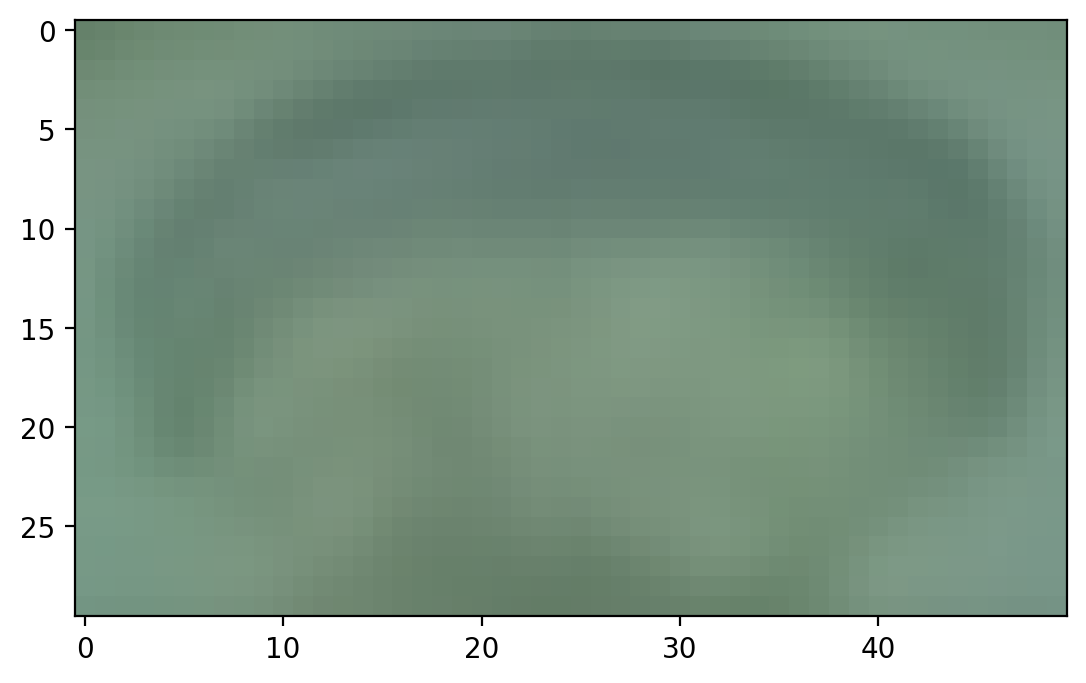

In [31]:
data = LoadDataset(
    TRAIN_DATASET_DIR,
    transforms.Compose([transforms.Resize(FIXED_IMG_SIZE)]),
)
dataset = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)

with torch.no_grad():
    ex = next(iter(dataset)).to(DEVICE)
    pred = autoencoder(ex)

plt.imshow(np.transpose(pred.cpu().numpy()[0], axes=(1, 2, 0)))

### We got loss~5.5 for positive imgs, let's calculate stats for negatives

In [54]:
data_val = LoadDataset(
    NEGATIVE_DATASET_DIR,
    transforms.Compose([transforms.Resize(FIXED_IMG_SIZE)]),
)
dataset_val = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)

autoencoder.eval()
l = []
with torch.no_grad():
    for i, x in enumerate(data_val):
        x = x.unsqueeze(0).to(DEVICE)
        p = autoencoder(x)
        l.append(((x - p) ** 2).sum().item())
        print(f"loss for negative sample {i + 1}: {l[-1]}")

print(f"min loss = {min(l)}")
print(f"mean loss = {np.mean(l)}")

loss for negative sample 1: 19.744293212890625
loss for negative sample 2: 22.14520263671875
loss for negative sample 3: 18.16210174560547
loss for negative sample 4: 19.1495304107666
loss for negative sample 5: 35.30286407470703
loss for negative sample 6: 19.652511596679688
loss for negative sample 7: 15.875557899475098
loss for negative sample 8: 15.68686294555664
loss for negative sample 9: 18.968942642211914
loss for negative sample 10: 12.721654891967773
loss for negative sample 11: 40.552734375
loss for negative sample 12: 21.443111419677734
loss for negative sample 13: 22.695350646972656
loss for negative sample 14: 15.401663780212402
loss for negative sample 15: 26.621822357177734
loss for negative sample 16: 28.74909782409668
loss for negative sample 17: 15.184796333312988
loss for negative sample 18: 14.713872909545898
loss for negative sample 19: 18.370807647705078
loss for negative sample 20: 12.375375747680664
loss for negative sample 21: 29.155614852905273
loss for negat

### Let's take threshold val = 12 and validate model with test data

In [74]:
THRESH = 12

In [64]:
class LoadTestDataset(Dataset):
    def __init__(self, dataset_path, annot, transform=None):
        self.dataset_path = dataset_path
        self.annot = annot
        self.transform = transform
        self.data, self.labels = self.__load_path()

    def __load_path(self):
        data = [
            os.path.join(self.dataset_path, el)
            for el in os.listdir(self.dataset_path)
        ]

        labels = {}
        with open(self.annot) as a:
            for l in [el.rstrip() for el in a.readlines()]:
                img, lab = l.split()
                labels[img] = int(lab)

        return data, labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = read_image(self.data[idx], mode=ImageReadMode.RGB)
        if self.transform:
            img = self.transform(img)

        return img / 255.0, self.labels[os.path.basename(self.data[idx])]

In [75]:
data_val = LoadTestDataset(
    TEST_DATASET_DIR,
    TEST_DATASET_LABELS_PATH,
    transforms.Compose([transforms.Resize(FIXED_IMG_SIZE)]),
)
dataset_val = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)

autoencoder.eval()
tp, tn, fp, fn = 0, 0, 0, 0
with torch.no_grad():
    for i, (x, y) in enumerate(data_val):
        x = x.unsqueeze(0).to(DEVICE)
        p = autoencoder(x)
        loss = ((x - p) ** 2).sum().item()

        if loss < THRESH and not y:
            tp += 1
        elif loss < THRESH and y:
            fp += 1
        elif loss >= THRESH and not y:
            fn += 1
        elif loss >= THRESH and y:
            tn += 1

print(f"TPR = {tp / (tp + fn)}")
print(f"TNR = {tn / (tn + fp)}")

TPR = 0.8455661664392906
TNR = 0.8217054263565892


## So we got ~83% for TPR and TNR!